# Cardiovascular adverse events associated with monoclonal antibody drugs in COVID-19 patients  

## Introduction  
Monoclonal antibody drugs have been used to treat COVID-19 patients. But the cardiovascular adverse events associated with these drugs have not been studied yet. In the study, we used publically availabe database of FDA Adverse Event Reporting System (FAERS) to study the adverse effects of these drugs.  FAERS is a database for the spontaneous reporting of adverse events and medication errors involving human drugs and therapeutic biological products. It is one of the largest pharmacovigilant database in the world.  

## Monoclonal antibodies to Treat COVID-19

Six monoclonal antibody drugs were authorized by FDA for treatment of COVID-19 under emergency use authorization (EUA). They are listed below.
- casirivimab and imdevimab, administered together
- bamlanivimab and etesevimab, administered together
- sotrovimab
- tocilizumab
- bebtelovimab
- tixagevimab and cilgavimab, administered as 2 separate consecutive intramuscular injections

More authorization information about these monoclonal antibodies are shown below. It is cited from https://www.cms.gov/monoclonal website.
- REGEN-COV (casirivimab and imdevimab, administered together) (EUA issued November 21, 2020, latest update January 24, 2022). On January 24, 2022, the FDA issued the following statement: Due to the high frequency of the Omicron variant, REGEN-COV is not currently authorized in any U.S. region. Therefore, REGEN-COV may not be administered for treatment or post-exposure prevention of COVID-19 under the Emergency Use Authorization until further notice by the Agency.
- Bamlanivimab and etesevimab, administered together (EUA issued February 9, 2021, latest update January 24, 2022). On January 24, 2022, the FDA issued the following statement: Due to the high frequency of the Omicron variant, bamlanivimab and etesevimab are not currently authorized in any U.S. region. Therefore, these drugs may not be administered for treatment or post-exposure prevention of COVID-19 under the Emergency Use Authorization until further notice by the Agency.
- Sotrovimab (EUA issued May 26, 2021, latest update February 23, 2022). On April 5, 2022, the FDA issued the following statement: Due to the high frequency of the Omicron BA.2 sub-variant, sotrovimab is not currently authorized in any U.S. region. Therefore, sotrovimab may not be administered for treatment of COVID-19 under the Emergency Use Authorization until further notice by the Agency. 
- Tocilizumab (EUA issued June, 24 2021)
- Bebtelovimab (EUA issued February 11, 2022)
- EVUSHELD (tixagevimab co-packaged with cilgavimab), administered as 2 separate consecutive intramuscular injections (EUA issued December 8, 2021, latest update May 17, 2022). Investigational monoclonal antibody product under EUA for pre-exposure prophylaxis of COVID-19

## Data source 

Quarterly datasets of adverse event reports are availabe in the FAERS database. Data in the period between January 2020 and June 2022 were downloaded. The dataset consists of the following seven tables:
- DEMO table contains patient demographic and administrative information, a single record for each event report
- DRUG table contains drug/biologic information for as many medications and were reported for the event (one ore more per event)
- REAC table contains all "Medical Dictionary for Regulatory Activities" (MedDRA) terms coded for the adverse event
- OUTC table contains patient outcomes for the event
- RPSR table contains report source for the event
- THER table contains drug therapy start dates and end dates for the reported drugs
- INDI table contains all MedDRA terms for the indications for use (diagnoses) for the reported drugs  

Data were imported into SQLite, a database management system.

## Data extraction  

Here, we study the adverse events of different treatments for COVID-19. The indications for use of the reported drugs can be found in the INDI table in the database. We use the following MedDRA terms to extract all the reports related to COVID-19 treatment.
- COVID-19 
- COVID-19 pneumonia
- Coronavirus infection
- COVID-19 treatment
- SARS-CoV-2 test positive
- Suspected COVID-19
- Corona virus infection
- Coronavirus test positive

Then the COVID-19 related caseid extracted from the INDI table is used to extract all other informations from rest of the tables in the database.

The SQL script used for data extraction is included in the file covid.sql. The datasets used in this study include four csv files: demo_covid.csv, drug_covid.csv, outc_covid.csv, reac_covid.csv.


## Detailed method

The following Notebook includes the detailed method and code for investigating the cardiovascular adverse events (CVAE) associated with monoclonal antibodies in COVID-19 patients.

In [1]:
# import Python libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)

Read datasets into Pandas DataFrame.

In [2]:
#load data
drug = pd.read_csv("drug_covid.csv")
demo = pd.read_csv("demo_covid.csv")
reac = pd.read_csv("reac_covid.csv")
outc = pd.read_csv("outc_covid.csv")

/Users/fuyuanjing/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Check the size of each DataFrame
print(f"the shape of drug table: {drug.shape}")
print(f"the shape of demo table: {demo.shape}")
print(f"the shape of reac table: {reac.shape}")
print(f"the shape of outc table: {outc.shape}")

the shape of drug table: (85011, 21)
the shape of demo table: (51297, 25)
the shape of reac table: (147793, 4)
the shape of outc table: (44903, 3)


### Remove duplicates

A case may be reported to FDA multiple times, each having sequentially incremented version numbers. The case can be identified by CASEID. There is also an unique PRIMARYID for identifying a FAERS report. This is a concatenated key of Case ID and Case Version Number.

For example, the following code shows that one case may have different versions.

In [4]:
(
    demo.groupby("caseid", as_index=False)["caseversion"]
    .count()
    .sort_values("caseversion", ascending=False)
    .head(10)
)

,caseid,caseversion
6644,18205933,6
8278,18351280,5
20011,19214011,4
17803,19013653,4
12003,18632613,4
4844,18042763,4
9595,18475506,4
1089,17778542,4
11558,18606736,4
4504,18012969,4


This table shows that there are 6 versions for caseid 18205933 in the demo table. 

The different versions are shown in the following table.

In [5]:
demo[demo["caseid"]==18205933]

,primaryid,caseid,caseversion,i_f_code,event_dt,mfr_dt,init_fda_dt,fda_dt,rept_cod,auth_num,...,age_grp,sex,e_sub,wt,wt_cod,rept_dt,to_mfr,occp_cod,reporter_country,occr_country
8339,182059339,18205933,9,F,20200809.0,20201217.0,20200827,20201221,EXP,NaN,...,NaN,M,Y,NaN,NaN,20201221.0,NaN,MD,FR,FR
13239,1820593313,18205933,13,F,20200809.0,20210222.0,20200827,20210225,EXP,NaN,...,NaN,M,Y,NaN,NaN,20210225.0,NaN,MD,FR,FR
19088,1820593315,18205933,15,F,20200809.0,20210602.0,20200827,20210608,EXP,NaN,...,NaN,M,Y,NaN,NaN,20210608.0,NaN,MD,FR,FR
23484,1820593318,18205933,18,F,20200809.0,20210806.0,20200827,20210812,EXP,NaN,...,NaN,M,Y,NaN,NaN,20210812.0,NaN,MD,FR,FR
27678,1820593319,18205933,19,F,20200809.0,20211008.0,20200827,20211015,EXP,NaN,...,NaN,M,Y,NaN,NaN,20211015.0,NaN,CN,FR,FR
38741,1820593321,18205933,21,F,20200809.0,20220331.0,20200827,20220406,EXP,NaN,...,NaN,M,Y,NaN,NaN,20220406.0,NaN,CN,FR,FR


To remove the duplicates, we only keep the most rescent version of the report, that is the record with biggest caseversion number.

In [6]:
demo = (
    demo.sort_values(["caseid", "caseversion"])
    .groupby("caseid", as_index=False)
    .last()
)
primaryid_list = demo["primaryid"]
drug = drug[drug["primaryid"].isin(primaryid_list)]
reac = reac[reac["primaryid"].isin(primaryid_list)]
outc = outc[outc["primaryid"].isin(primaryid_list)]

In [7]:
# Check the shape of each dataframe
print("After removing duplicates")
print(f"the shape of drug table: {drug.shape}")
print(f"the shape of demo table: {demo.shape}")
print(f"the shape of reac table: {reac.shape}")
print(f"the shape of outc table: {outc.shape}")

After removing duplicates
the shape of drug table: (80433, 21)
the shape of demo table: (48985, 25)
the shape of reac table: (139290, 4)
the shape of outc table: (41695, 3)


### Data preparation

Add some new columns in the demo dataframe that will be used in the following analysis.

In [8]:
# change the data type of the fda_dt column and add a new column for month
demo["fda_dt"] = pd.to_datetime(demo["fda_dt"], format="%Y%m%d")
demo["month"] = demo["fda_dt"].dt.strftime("%Y-%m")
# convert all ages to years
demo["age_adj"] = demo["age"] * demo['age_cod'].map( \
    {'DEC':10, 'YR':1.0, 'MON':1/12, 'WK':7/365, 'DY':1/365, 'HR':1/365/24})
# add age group

#create a function to put patents into different age groups
def group_age(age):
    if np.isnan(age):
        return 'unknown'
    elif age <= 18:
        return '0-18'
    elif age <= 35:
        return '19-35'
    elif age <= 50:
        return '36-50'
    elif age <= 65:
        return '51-65'
    else:
        return '>65'

demo["age_group"] = demo["age_adj"].map(group_age)
# convert all body weights to kilograms
demo["wt_adj"] = demo["wt"] * demo["wt_cod"].map({"KG": 1.0, "LBS": 0.453592})

### Exploratory data analysis

**This part is not included in the paper.**

This analysis is to get some some general overview of the datasets.

In [9]:
# total number of cases
print("The total number of reports is ", demo["caseid"].nunique())

The total number of reports is  48985


**What are the AE report numbers by month? How does that compare with the monthly COVID-19 cases reported by CDC?**

To look into that, I downloaded the data for number of COVID-19 cases in US from the CDC website.
https://covid.cdc.gov/covid-data-tracker/#trends_dailycases_select_00


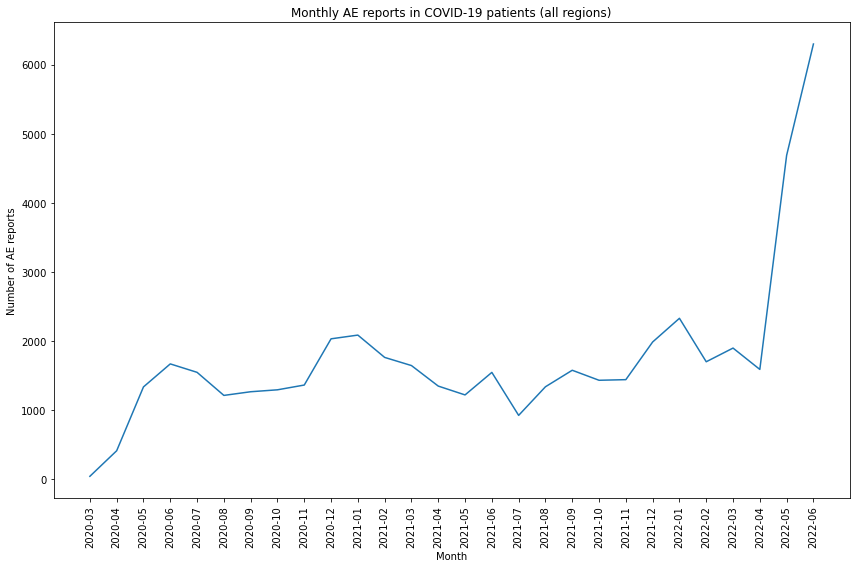

In [10]:
# count monthly AE reports in COVID-19 patients
monthly_cases = demo.groupby("month", as_index=False)["caseid"].nunique().rename(columns={"caseid":"No_cases"}).iloc[2:]
plt.plot(monthly_cases['month'], monthly_cases['No_cases'])
plt.title('Monthly AE reports in COVID-19 patients (all regions)')
plt.xlabel('Month')
plt.ylabel('Number of AE reports')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

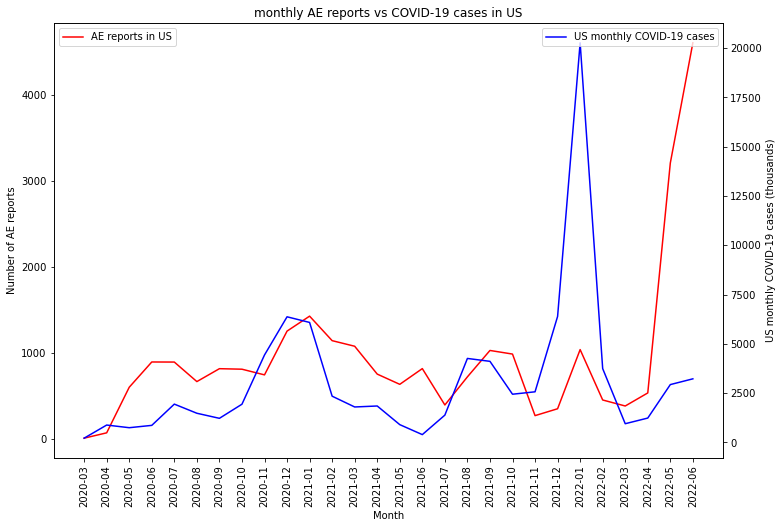

In [11]:
# count montly AE reports in COVID-19 patients in US
monthly_cases_us = (
    demo[demo["occr_country"]=="US"]
    .groupby("month", as_index=False)["caseid"]
    .nunique()
    .rename(columns={"caseid":"No_cases"})
)

us_covid = pd.read_csv("us daily covid cases.csv", skiprows=2)
us_covid["Date"]=pd.to_datetime(us_covid["Date"])
us_covid = us_covid.assign(month = lambda df : df["Date"].dt.strftime("%Y-%m"))
us_covid_monthly = us_covid.groupby("month", as_index=False)["New Cases"].sum().iloc[2:30] #only look 2020-03 to 2022-06

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(monthly_cases_us['month'], monthly_cases_us['No_cases'], color="red", label = "AE reports in US")
ax2.plot(us_covid_monthly["month"], us_covid_monthly["New Cases"]/1000, color="blue",  label = "US monthly COVID-19 cases")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of AE reports")
ax2.set_ylabel("US monthly COVID-19 cases (thousands)")
ax1.set_xticks(monthly_cases["month"])
ax1.set_xticklabels(monthly_cases["month"], rotation=90)
ax1.legend()
ax2.legend(loc=1)
plt.title("monthly AE reports vs COVID-19 cases in US")
plt.show()

Comparing the monthly AE reports and COVID-19 cases, we found they share some similar patterns. Specifically, there are three peaks in the monthly AE reports that coincide with the peaks in the monthly COVID-19 reports. There is a peak for AE reports in Decemeber 2020 and January 2021, when number of COVID cases also peaked. There is a valley for AE reports during July 2021. This is also the month when number of COVID-19 cases was very low. Due to the omicron variant, COVID-19 cases surged dramatically in January 2022, and AE reports also increased in this month, but only to a level that is similar to the peak in December 2020. This reflects the fact that omicron variant is much milder than the previous variants and therefore less COVID-19 patients need treatment.

**Where are the adverse events reported**

In [12]:
AE_by_country = pd.DataFrame({"No_reports": demo["occr_country"].value_counts()})
AE_by_country["Percentage"] = AE_by_country["No_reports"]/AE_by_country["No_reports"].sum()
AE_by_country.head(10)

,No_reports,Percentage
US,26517,0.612628
JP,2766,0.063904
ES,2346,0.054200
IT,2337,0.053992
FR,2020,0.046669
TR,535,0.012360
IN,529,0.012222
IR,528,0.012199
BR,485,0.011205
CN,461,0.010651


In this dataset, about 61% of the AE reports are from US.

**What's the age distribution of the patients**

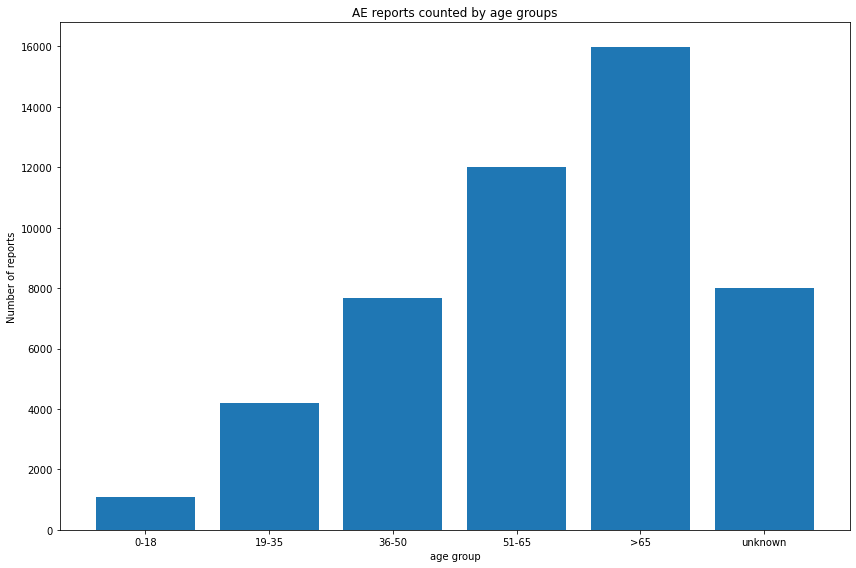

In [13]:
AE_by_agegroup = demo["age_group"].value_counts().sort_index()
plt.bar(AE_by_agegroup.index, AE_by_agegroup)
plt.title('AE reports counted by age groups')
plt.xlabel('age group')
plt.ylabel('Number of reports')
plt.tight_layout()
plt.show()

This seems consistant with our knowledge that older people are at high risk.

**Check the drugs used for COVID treatment**

In [14]:
# find all drug names that contain string "BAMLANIVIMAB"
drug.loc[drug["drugname"].str.contains("BAMLANIVIMAB"), "drugname"].unique()

array(['BAMLANIVIMAB.', 'BAMLANIVIMAB INJECTABLE', 'BAMLANIVIMAB 700MG',
       'BAMLANIVIMAB INJECTION',
       'BAMLANIVIMAB (700 MG / 200 ML NACL 0.9% SOLUTION)',
       'BAMLANIVIMAB (EUA)', 'BAMLANIVIMAB 700 MG IV / 200 ML NACL',
       'BAMLANIVIMAB (LY-COV555)', 'BAMLANIVIMAB 700MG IV',
       'IV-BAMLANIVIMAB',
       'BAMLANIVIMAB TREATMENT UNDER EMERGENCY USE AUTHORIZATION',
       'BAMLANIVIMAB INFUSION',
       'BAMLANIVIMAB 700 MG IN SODIUM CHLORIDE (NS) 0.9 % 200 ML IVPB',
       'BAMLANIVIMAB 700MG/200ML NS', 'BAMLANIVIMAB 200MG/20ML',
       'BAMLANIVIMAB 700MG/20ML', 'BAMLANIVIMAB EUA',
       'BAMLANIVIMAB FOR EUA', 'BAMLANIVIMAB 700 MG IV INFUSION',
       'BAMLANIVIMAB 700MG/20ML LILLY',
       'BAMLANIVIMAB TREATMENT UNDER EMERGENCY USE AUTHORIZATION (EUA)^',
       'BAMLANIVIMAB 700 MG INJECTION', 'IV BAMLANIVIMAB',
       'BAMLANIVIMAB INJ', 'BAMLANIVIMAB 700 MG',
       'BAMLANIVIMAB (EUA) 700MG IN SODIUM CHLORIDE 0.9% 200ML IVPB',
       'BAMLANIVIMAB (EMERGENC

The names used in the reporting system for one specific drug can be very diverse as shown in the above list. But we found the active ingredient name in the prod_ai column is very generic. So, we use prod_ai names to identify the drugs.

In [15]:
# check missing values in prod_ai column
drug.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80433 entries, 0 to 85010
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   primaryid      80433 non-null  int64  
 1   caseid         80433 non-null  int64  
 2   drug_seq       80433 non-null  int64  
 3   role_cod       80433 non-null  object 
 4   drugname       80433 non-null  object 
 5   prod_ai        80037 non-null  object 
 6   val_vbm        80433 non-null  int64  
 7   route          61117 non-null  object 
 8   dose_vbm       60437 non-null  object 
 9   cum_dose_chr   4248 non-null   float64
 10  cum_dose_unit  4247 non-null   object 
 11  dechal         64665 non-null  object 
 12  rechal         15280 non-null  object 
 13  lot_num        31879 non-null  object 
 14  exp_dt         5429 non-null   object 
 15  nda_num        39616 non-null  float64
 16  dose_amt       33498 non-null  float64
 17  dose_unit      33498 non-null  object 
 18  dose_f

The column of prod_ai contains 396 missing values. The following code is to check whether the drug names of these rows contain any of our target drugs. 

In [16]:
ai_missing_rows = drug["prod_ai"].isna()
drug_names = ["CASIRIVIMAB", "IMDEVIMAB", "BAMLANIVIMAB", "ETESEVIMAB", "SOTROVIMAB", "TOCILIZUMAB", "BEBTELOVIMAB", 
"TIXAGEVIMAB", "CILGAVIMAB"]
for d in drug_names:
    print("drug name containing string {}: {}".format(d, drug.loc[ai_missing_rows, "drugname"].str.upper().str.contains(d).sum()))

drug name containing string CASIRIVIMAB: 0
drug name containing string IMDEVIMAB: 0
drug name containing string BAMLANIVIMAB: 0
drug name containing string ETESEVIMAB: 0
drug name containing string SOTROVIMAB: 0
drug name containing string TOCILIZUMAB: 0
drug name containing string BEBTELOVIMAB: 0
drug name containing string TIXAGEVIMAB: 0
drug name containing string CILGAVIMAB: 0


We found that none of the prod_ai missing rows is related to our targeted drugs. Therefore, we use the corresponding drugname to fill the missing values in the prod_ai column.

In [17]:
drug.loc[ai_missing_rows, "prod_ai"] = drug.loc[ai_missing_rows, "drugname"]

**what are the top drugs reported**

In [18]:
(
    drug.groupby("prod_ai", as_index=False)["caseid"]
    .nunique()
    .rename(columns={"caseid":"count"})
    .sort_values("count", ascending=False)
    .head(20)
)

,prod_ai,count
747,NIRMATRELVIR\RITONAVIR,9530
876,REMDESIVIR,7597
537,HYDROXYCHLOROQUINE,6603
980,TOCILIZUMAB,5181
113,BAMLANIVIMAB,4906
104,AZITHROMYCIN ANHYDROUS,4157
180,CASIRIVIMAB\IMDEVIMAB,3365
661,LOPINAVIR\RITONAVIR,3348
376,DEXAMETHASONE,2739
212,CEFTRIAXONE,1839


The above table shows the top 20 drugs reported.  

The role of drug in adverse event was also reported in this system. They are coded as below:
- PS: primary suspect drug
- SS: secondary suspect drug
- C: concomitant
- I: Interacting

**Overview of the drug roles in adverse events**

In [19]:
drug_roles = {"Any drug": drug["role_cod"].value_counts()}
for d in drug_names:
    drug_roles[d] = drug.loc[drug["prod_ai"].str.contains(d), "role_cod"].value_counts()
drug_roles = pd.DataFrame(drug_roles)
drug_roles.sort_values("Any drug", ascending=False)


,Any drug,CASIRIVIMAB,IMDEVIMAB,BAMLANIVIMAB,ETESEVIMAB,SOTROVIMAB,TOCILIZUMAB,BEBTELOVIMAB,TIXAGEVIMAB,CILGAVIMAB
PS,44391,3707,3362,4898,1362.0,1769.0,3091,469.0,92.0,91.0
SS,25140,90,382,703,440.0,46.0,1748,2.0,11.0,14.0
C,9428,10,13,6,4.0,22.0,392,NaN,1.0,1.0
I,1474,2,2,1,NaN,NaN,29,NaN,NaN,NaN


The above table shows the roles of drugs in the adverse events. We will focus on the primary and secondary suspected drugs.

In [20]:
drug_ps = drug[drug["role_cod"].isin(["PS", "SS"])]
drug_ps.shape

(69531, 21)

**How many primary or secondary suspected drugs were reported for each patient?**

In [21]:
ps_drugs_per_patient = (
    drug_ps.groupby("caseid", as_index=False)["prod_ai"]
    .nunique()
    .rename(columns={"prod_ai":"count"})
    .sort_values("count", ascending=False)
)
drug_no_count = pd.DataFrame(ps_drugs_per_patient["count"].value_counts().sort_index())
drug_no_count.index.rename("drug_no", inplace=True)
drug_no_count["Percentage"] = drug_no_count["count"]/drug_no_count["count"].sum()
drug_no_count

,count,Percentage
drug_no,,
1,36845,0.778520
2,5395,0.113994
3,2449,0.051746
4,1343,0.028377
5,601,0.012699
6,312,0.006592
7,166,0.003508
8,92,0.001944
9,51,0.001078


The above table shows that about 78% events involve a single primary suspected drug, 11% events inclove two primary or secondary suspected drugs, and 11% events involve three or more drugs.

**check the combination of different drugs**

For each patient (caseid), we combine all the primary and secondary suspected drugs. Then we count how many cases were reported for each drug combination.

In [22]:
(
    drug_ps.groupby("caseid", as_index=False)["prod_ai"]
    .agg(set)
    .assign(drug_comb=lambda df : df["prod_ai"].astype("string"))
    .groupby("drug_comb", as_index=False)["caseid"]
    .count()
    .sort_values("caseid", ascending=False)
    .rename(columns={"caseid":"count"})
    .head(20)
)

,drug_comb,count
2612,{'NIRMATRELVIR\\RITONAVIR'},9499
3078,{'REMDESIVIR'},5652
627,{'BAMLANIVIMAB'},3797
682,{'CASIRIVIMAB\\IMDEVIMAB'},3338
3406,{'TOCILIZUMAB'},3006
3275,{'SOTROVIMAB'},1765
1814,{'HYDROXYCHLOROQUINE'},1461
1388,"{'ETESEVIMAB', 'BAMLANIVIMAB'}",1078
2557,{'MOLNUPIRAVIR'},986
379,"{'AZITHROMYCIN ANHYDROUS', 'HYDROXYCHLOROQUINE'}",802


The above table shows the top 20 combinations of primary and secondary suspected drugs.

**Overview of the adverse reactions**

In [23]:
reac.head()

,primaryid,caseid,pt,drug_rec_act
0,174278541,17427854,Anal incontinence,NaN
1,174278541,17427854,Blood pressure decreased,NaN
2,174278541,17427854,Chest discomfort,NaN
3,174278541,17427854,Cold sweat,NaN
4,174278541,17427854,Dizziness,NaN


The adverse reactions are reported in the reac table coded with MedDRA preferred terms. Here we count the most reported pt among all patients.

In [24]:
(
    reac.groupby("pt", as_index=False)["caseid"]
    .nunique()
    .rename(columns={"caseid":"count"})
    .sort_values("count", ascending=False)
    .head(20)
)

,pt,count
2587,Off label use,12349
588,COVID-19,6237
1042,Disease recurrence,3502
1140,Dyspnoea,2387
1931,Infusion related reaction,2186
3008,Product use in unapproved indication,1913
2471,Nausea,1889
1127,Dysgeusia,1790
1024,Diarrhoea,1741
3107,Pyrexia,1696


The top medical terms are related to COVID-19 symptoms.

**Overview the AE outcomes**

In [25]:
outc.head()

,primaryid,caseid,outc_cod
0,174278541,17427854,LT
1,174278541,17427854,OT
3,174545151,17454515,OT
6,174836042,17483604,OT
7,174836432,17483643,OT


Here is the meaning of the outcome codes.

- DE        Death 
- LT        Life-Threatening 
- HO        Hospitalization - Initial or Prolonged  
- DS        Disability 
- CA        Congenital Anomaly 
- RI        Required Intervention to Prevent Permanent Impairment/Damage 
- OT        Other Serious (Important Medical Event)

I noticed that here may be more than one outcome for one case. In this situation, only the most serious outcome is kept.

In [26]:
# the outcomes are ordered from most serious to least serious
outcome_cod = ["DE", "LT", "HO", "DS", "CA", "RI", "OT"]
outcome_num_dict = {v:i for i, v in enumerate(outcome_cod)}
outc["code_num"] = outc["outc_cod"].map(outcome_num_dict)
outc = outc.sort_values(["caseid", "code_num"]).groupby("caseid", as_index=False).first()

**Count AE outcomes**

In [27]:
(
    outc.groupby("outc_cod", as_index=False)["caseid"]
    .nunique()
    .rename(columns={"caseid":"count"})
    .sort_values("count", ascending=False)
    .assign(percentage = lambda df : df["count"]/df["count"].sum())
)

,outc_cod,count,percentage
5,OT,13015,0.409277
3,HO,9474,0.297925
1,DE,6223,0.195692
4,LT,2156,0.067799
6,RI,745,0.023428
2,DS,178,0.005597
0,CA,9,0.000283


### Definition of CVAE  

Cardiovascular adverse event was identified as report with MedDRA preferred terms falling into at least one of the following SMQ categories using the Narrow scope (version 25.0). 

Reference: Cardiovascular Toxicity of Tyrosine Kinase Inhibitors Used in Chronic Myeloid Leukemia: An Analysis of the FDA Adverse Event Reporting System Database (FAERS)  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7226142/


|       SMQ Name          |       SMQ code        |   Sub-SMQ   |
|-------------------------|-----------------------|-------------|
| Cardiac arrhythmias	|  20000049  | Arrhythmia related investigations, signs and symptoms<br> Bradyarrhythmias (incl conduction defects and disorders of sinus node function)<br> Cardiac arrhythmia terms, nonspecific <br> Tachyarrhythmias (incl supraventricular and ventricular tachyarrhythmias) <br> Congenital and neonatal arrhythmias |
| Cardiac failure	    |  20000004  | 
| Cardiomyopathy	    |  20000150  |
| Embolic and thrombotic events	| 20000081 | Embolic and thrombotic events, arterial <br> Embolic and thrombotic events, venous <br> Embolic and thrombotic events, vessel type unspecified and mixed arterial and venous |
| Hypertension	| 20000147 |
| Ischemic heart disease |	20000043 | Myocardial infarction <br> Other ischaemic heart disease |
| Pulmonary hypertension |	20000130 |
| Torsade de pointes/QT prolongation |	20000001 |

In [28]:
# load MedDRA preferred terms for cardiovascular adverse events
cvae_pt = pd.read_excel("cvae categories.xlsx")
cvae_pt.head()

,top_category,sub_category,pt
0,Cardiac arrhythmias,"Arrhythmia related investigations, signs and s...",Chronotropic incompetence
1,Cardiac arrhythmias,"Arrhythmia related investigations, signs and s...",Early repolarisation syndrome
2,Cardiac arrhythmias,"Arrhythmia related investigations, signs and s...",Electrocardiogram repolarisation abnormality
3,Cardiac arrhythmias,"Arrhythmia related investigations, signs and s...",Electrocardiogram RR interval prolonged
4,Cardiac arrhythmias,"Arrhythmia related investigations, signs and s...",Electrocardiogram U wave inversion


### Sensitivity analysis  

To perform sensitivity analysis, uncomment the following code and re-run all code.

In [62]:
# ## only keep physician, pharmacist, and health professional reported cases
# reporter_list = ["MD", "PH", "HP"]
# demo = demo[demo["occp_cod"].isin(reporter_list)]
# primaryid_list = demo["primaryid"]
# drug_ps = drug_ps[drug_ps["primaryid"].isin(primaryid_list)]
# reac = reac[reac["primaryid"].isin(primaryid_list)]
# outc = outc[outc["primaryid"].isin(primaryid_list)]

### Utility functions  

Create some functions that will be useful in the following analysis

In [63]:
def select_caseid_by_drug(df, drugname_list):
    """
    This function select case ids that having specified drug/drugs as primary or secondary suspected drugs.
    Parameters:
        df - pd.DataFrame, the drug DataFrame or a subset of it
        drugname_list - string or list of string, drug names
    Returns:
        set of case ids
    """
    if type(drugname_list) is str:
        drugname_list = [drugname_list]
    drug_agg_df = df.groupby("caseid", as_index=False)["prod_ai"].agg(set)
    caseid_selected = drug_agg_df.loc[drug_agg_df["prod_ai"]==set(drugname_list), "caseid"]
    return set(caseid_selected)

In [64]:

def count_cvae_by_drug(caseid_selected, group_label, pt_category):
    """
    This function counts the CVAE for a give set of case ids, as well as calculate some descriptive statistics
    
    Parameters:
        caseid_selected - set or list, a set of case ids for counting the CAVEs
        group_label - string, name given to the set of case ids, usually the drug names
        pt_category - pd.DataFrame, a dataframe containing two columns, the first column is the pt and second column is the SMQ category

    Return:
        dictionary containing the descriptive statistics and CVAE counting results
    """
    
    #use a dictionary to save the result
    result = {"Group label": group_label}
    
    drug_df = drug_ps[drug_ps["caseid"].isin(caseid_selected)]
    demo_df = demo[demo["caseid"].isin(caseid_selected)]
    # demo_df = demo_df.sort_values(["caseid", "caseversion"]).groupby("caseid", as_index=False).last()
    reac_df = reac[reac["caseid"].isin(caseid_selected)]
    outc_df = outc[outc["caseid"].isin(caseid_selected)]

    # total number of reports
    result["Total reports"] = len(caseid_selected)
    # find number of cases with age reported
    mask = demo_df["age_adj"].notna()
    result["Age reported"] = demo_df.loc[mask, "caseid"].nunique()
    # report age mean
    result["Age mean"] = demo_df["age_adj"].mean()
    result["Age std"] = demo_df["age_adj"].std()

    # report weight mean and std
    result["Weight reported"] = demo_df[demo_df["wt_adj"].notna()].shape[0]
    result["Weight mean"] = demo_df["wt_adj"].mean()
    result["Weight std"] = demo_df["wt_adj"].std()

    # find number of cases with sex reported
    result["Male"] = demo_df.loc[demo_df["sex"]=="M", "caseid"].nunique()
    result["Female"] = demo_df.loc[demo_df["sex"]=="F", "caseid"].nunique()
    result["Sex reported"] = result["Male"] + result["Female"]

    # reporters of the event
    result["Reporter total"] = demo_df[demo_df["occp_cod"].notna()].shape[0]
    result["Reporter groups"] = demo_df.groupby("occp_cod")["caseid"].nunique().sort_index()

    # country of the event
    result["Country reported"] = demo_df[demo_df["occr_country"].notna()].shape[0]
    result["Country groups"] = demo_df.groupby("occr_country")["caseid"].nunique().sort_index()

    # count cardiovascular adverse events
    pt_category = pt_category.copy()
    pt_category.columns = ["pt", "category"]
    cvae_df = reac_df.merge(pt_category, on="pt")
    result["total CVAE"] = cvae_df["caseid"].nunique()
    result["CVAE by pt"] = cvae_df.groupby("pt")["caseid"].nunique().sort_index()
    result["CVAE by group"] = cvae_df.groupby("category")["caseid"].nunique().sort_index()

    # count outcome
    result["outcome reported"] = outc_df.shape[0]
    result["outcome group"] = outc_df.groupby("outc_cod")["caseid"].nunique().sort_index()
    
    return result

In [65]:
caseid_selected = drug_ps["caseid"].unique()


In [66]:
len(caseid_selected)

34530

In [67]:
count_cvae_by_drug(caseid_selected, "All", cvae_pt[["pt", "sub_category"]])

{'Group label': 'All',
 'Total reports': 34530,
 'Age reported': 29799,
 'Age mean': 58.45536897824254,
 'Age std': 18.990639415445077,
 'Weight reported': 13702,
 'Weight mean': 88.39909792088743,
 'Weight std': 29.455865483713016,
 'Male': 17295,
 'Female': 13516,
 'Sex reported': 30811,
 'Reporter total': 34530,
 'Reporter groups': occp_cod
 HP    12593
 MD     9551
 PH    12386
 Name: caseid, dtype: int64,
 'Country reported': 30973,
 'Country groups': occr_country
 AE       37
 AF       12
 AL        4
 AM        4
 AR       38
       ...  
 US    16044
 UY        3
 VE        6
 VN        5
 ZA       58
 Name: caseid, Length: 127, dtype: int64,
 'total CVAE': 3905,
 'CVAE by pt': pt
 Accelerated idioventricular rhythm      2
 Acute cardiac event                     1
 Acute coronary syndrome                14
 Acute myocardial infarction           109
 Acute pulmonary oedema                 18
                                      ... 
 Ventricular extrasystoles              61
 

### Overview of the CVAE of monoclonal antibodies

Now we focus the study on monoclonal antibodies

1. casirivimab and imdevimab
2. bamlanivimab and etesevimab
3. sotrovimab
4. tocilizumab
5. bebtelovimab
6. tixagevimab and cilgavimab

In this list, 1, 2, and 6 are the combination of two antibodies. According to FDA's EUA, they should be administered together. But we also checked if there are cases with only one of the two antibodies reported. So we included the following drug combinations in our target list.

- casirivimab alone
- imdevimab alone
- casirivimab and imdevimab combined
- bamlanivimab alone
- etesevimab alone
- bamlanivimab and etesevimab combined
- sotrovimab
- tocilizumab
- bebtelovimab
- tixagevimab alone
- cilgavimab alone
- tixagevimab and  cilgavimab combined

**Definition of the AE case**  
An AE case for a specific drug or a combination of drugs is defined as a patient (identified by caseid) whose reported primary and secondary suspected drugs match exactly the specific drug or a set of drugs.

In [68]:
# find the case ids for each manoclonal antibodies
# store them in a dictionary whoes keys are drug names, and values are sets of case ids.
ma_drugs = ["CASIRIVIMAB", "IMDEVIMAB", 'CASIRIVIMAB+IMDEVIMAB', 'BAMLANIVIMAB', "ETESEVIMAB", 'BAMLANIVIMAB+ETESEVIMAB', 
'SOTROVIMAB', 'TOCILIZUMAB', "BEBTELOVIMAB", "TIXAGEVIMAB", "CILGAVIMAB", "TIXAGEVIMAB+CILGAVIMAB"]
ma_drug_caseids = []
for d in ma_drugs:
    if "+" in d:
        d_list = d.split("+")
        caseid_set1 = select_caseid_by_drug(drug_ps, d_list)
        caseid_set2 = select_caseid_by_drug(drug_ps, d_list[0] + "\\" + d_list[1])
        caseid_set3 = select_caseid_by_drug(drug_ps, d_list[1] + "\\" + d_list[0])
        ma_drug_caseids.append(caseid_set1.union(caseid_set2, caseid_set3))
    else:
        ma_drug_caseids.append(select_caseid_by_drug(drug_ps, d))
ma_drug_case_dict = dict(zip(ma_drugs, ma_drug_caseids))


In [69]:
# create a function to count the number of total AE, CVAE, and monthly reports
def drug_overview(ma_drug_case_dict):
    events_monthly = {}
    events_drug_overview = {}
    for d, caseid_set in ma_drug_case_dict.items():
        events_monthly[d] = demo[demo["caseid"].isin(caseid_set)].groupby("month")["caseid"].nunique().sort_index()
        cvae_count = count_cvae_by_drug(caseid_set, d, cvae_pt[["pt", "sub_category"]])
        events_drug_overview[d] = {
            "total_reports": cvae_count["Total reports"],
            "total_CVAE": cvae_count["total CVAE"]
        }
    events_monthly = pd.DataFrame(events_monthly)
    events_drug_overview = pd.DataFrame(events_drug_overview)
    return events_monthly, events_drug_overview

In [70]:
events_monthly, events_drug_overview = drug_overview(ma_drug_case_dict)
events_drug_overview

,CASIRIVIMAB,IMDEVIMAB,CASIRIVIMAB+IMDEVIMAB,BAMLANIVIMAB,ETESEVIMAB,BAMLANIVIMAB+ETESEVIMAB,SOTROVIMAB,TOCILIZUMAB,BEBTELOVIMAB,TIXAGEVIMAB,CILGAVIMAB,TIXAGEVIMAB+CILGAVIMAB
total_reports,57,5,2774,2745,12,1254,1450,2784,243,0,1,74
total_CVAE,3,1,287,373,1,121,67,197,34,0,0,9


The above table shows the number of AE and CVAE for each drug. Because the case numbers for some drugs are small, they are not included in the final analysis.

In [71]:
ma_drugs_selected = ['CASIRIVIMAB+IMDEVIMAB', 'BAMLANIVIMAB', 'BAMLANIVIMAB+ETESEVIMAB', 
'SOTROVIMAB', 'TOCILIZUMAB', "BEBTELOVIMAB", "TIXAGEVIMAB+CILGAVIMAB"]
ma_drug_case_selected = {d:ma_drug_case_dict[d] for d in ma_drugs_selected}

In [72]:
events_monthly_short, events_drug_overview_short = drug_overview(ma_drug_case_selected)

<AxesSubplot:xlabel='month'>

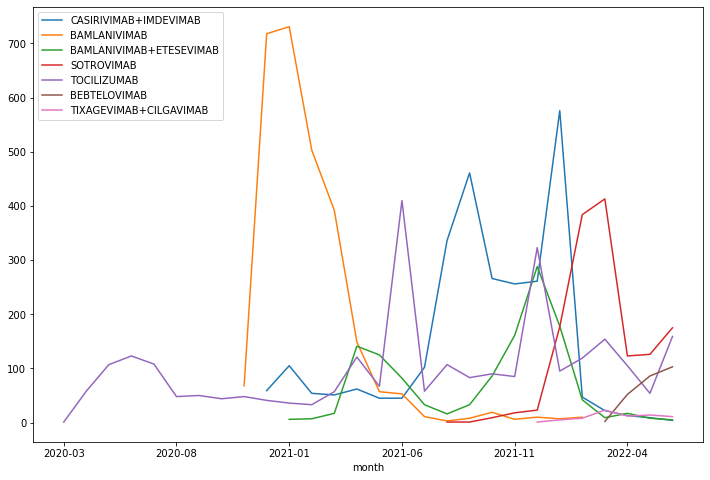

In [73]:
events_monthly_short.plot()

The above figure shows the monthly AE case numbers for each drug. Tocilizumab has been used sinced the breakout of the COVID-19 in early 2020. While other drugs were approved for COVID-19 treatment later by FDA under EUA. The AE reports for those drugs showed up later.

The table below shows the total numbers of AE and CVAE for each drug.

In [74]:
events_drug_overview_short

,CASIRIVIMAB+IMDEVIMAB,BAMLANIVIMAB,BAMLANIVIMAB+ETESEVIMAB,SOTROVIMAB,TOCILIZUMAB,BEBTELOVIMAB,TIXAGEVIMAB+CILGAVIMAB
total_reports,2774,2745,1254,1450,2784,243,74
total_CVAE,287,373,121,67,197,34,9


### Descriptive analysis  

Descriptive analysis fo the cases for each seelcted drug was performed using the following code. For continous variables, such as age and body weight, mean and standard deviation were reported. For categorial variables, such as country reported, outcomes and adverse events, the numbers were counted.


In [75]:

drug_case_dict = {"All treatment" : set(drug_ps["caseid"])}
for k, v in ma_drug_case_selected.items():
    drug_case_dict[k] = v

reporter_treatment_df = {}
country_treatment_df = {}
cvae_treatment_df = {}
outcome_treatment_df = {}
overview_treatment_df = {}
overview_index = ["Total reports", "Age reported", "Age mean", "Age std", "Weight reported", 
                  "Weight mean", "Weight std", "Sex reported", "Male", "Female", "Reporter total", 
                  "Country reported", "total CVAE", "outcome reported"]

for treatment_name, caseids in drug_case_dict.items():
    result = count_cvae_by_drug(caseids, treatment_name, cvae_pt[["pt", "top_category"]])
    reporter_treatment_df[treatment_name] = result["Reporter groups"]
    country_treatment_df[treatment_name] = result["Country groups"]
    cvae_treatment_df[treatment_name] = result["CVAE by group"]
    outcome_treatment_df[treatment_name] = result["outcome group"]
    # print({k : result[k] for k in overview_index})
    overview_treatment_df[treatment_name] = {k : result[k] for k in overview_index}

reporter_treatment_df = pd.DataFrame(reporter_treatment_df)
country_treatment_df = pd.DataFrame(country_treatment_df)
cvae_treatment_df = pd.DataFrame(cvae_treatment_df)
outcome_treatment_df = pd.DataFrame(outcome_treatment_df)
overview_treatment_df = pd.DataFrame(overview_treatment_df)
all_df = [overview_treatment_df, reporter_treatment_df, country_treatment_df, cvae_treatment_df, outcome_treatment_df]
cvae_overview = pd.concat(all_df, axis=0).fillna(0).astype(int)
cvae_overview

,All treatment,CASIRIVIMAB+IMDEVIMAB,BAMLANIVIMAB,BAMLANIVIMAB+ETESEVIMAB,SOTROVIMAB,TOCILIZUMAB,BEBTELOVIMAB,TIXAGEVIMAB+CILGAVIMAB
Total reports,34530,2774,2745,1254,1450,2784,243,74
Age reported,29799,2685,2534,1178,1114,1500,221,69
Age mean,58,55,66,52,48,60,50,56
Age std,18,19,15,19,21,16,19,21
Weight reported,13702,1825,2113,864,412,705,179,55
...,...,...,...,...,...,...,...,...
DS,61,6,1,0,1,3,0,0
HO,7963,1005,1405,360,184,531,39,28
LT,1746,103,87,60,32,109,14,11
OT,10897,791,521,302,151,794,98,16


In [76]:
# save the result to csv file
cvae_overview.to_csv("cvae_overview.csv")

### Disproportionality analysis

The ROR was used as a measure of disproportionality between cases and non-cases. In this study, ROR is the ratio of the odds of the number of CVAE related to a monoclonal antibody compared to those related to all other drugs. Its confidence interval was calculated with an alpha risk of 5%.  

Here are the formulas.
<img src="formulas.png">

IC_975 = IC + 2.4 * (a+0.5)^(-1/2) - 0.5 * (a + 0.5)^(-3/2)

The list below shows the CVAE categories we included in the analysis.

In [77]:
event_list = ["total CVAE"] + sorted(cvae_pt["top_category"].unique())
event_list

['total CVAE',
 'Cardiac arrhythmias ',
 'Cardiac failure',
 'Cardiomyopathy ',
 'Embolic and thrombotic events ',
 'Hypertension',
 'Ischaemic heart disease ',
 'Pulmonary hypertension',
 'Torsade de pointes/QT prolongation']

In [78]:
disprop_df = pd.DataFrame()
n_reports = cvae_overview.loc["Total reports", "All treatment"]
for d in ma_drug_case_selected.keys():
    drug_label = pd.Series(d + " vs All others", index=event_list)
    event_intervention = cvae_overview.loc[event_list, d]
    other_event_intervention = cvae_overview.loc["Total reports", d] - event_intervention
    event_comparator = cvae_overview.loc[event_list, "All treatment"] - event_intervention
    other_event_comparator = n_reports - cvae_overview.loc["Total reports", d] - event_comparator
    temp = {
        "drug label" : drug_label,
        "event intervention" : event_intervention,
        "other event intervention" : other_event_intervention,
        "event comparator" : event_comparator,
        "other event comparator": other_event_comparator
    }
    disprop_df = pd.concat([disprop_df, pd.DataFrame(temp).reset_index()], axis=0, ignore_index=True)

In [79]:
a, b, c, d = "event intervention", "other event intervention", "event comparator", "other event comparator"
disprop_df["ROR"] = (disprop_df[a] / disprop_df[b]) / (disprop_df[c] / disprop_df[d])
disprop_df["SE_logROR"] = np.sqrt(1/disprop_df[a] + 1/disprop_df[b] + 1/disprop_df[c] + 1/disprop_df[d])
disprop_df["CI95_low"] = disprop_df["ROR"] * np.exp(-1.96*disprop_df["SE_logROR"])
disprop_df["CI95_high"] = disprop_df["ROR"] * np.exp(1.96*disprop_df["SE_logROR"])
N_exp = ((disprop_df[a] + disprop_df[b]) * (disprop_df[a] + disprop_df[c])) / (disprop_df[a] + disprop_df[b] + disprop_df[c] + disprop_df[d])
disprop_df["IC"] = np.log2((disprop_df[a] + 0.5) / (N_exp + 0.5))
disprop_df["IC_025"] = disprop_df["IC"] - 3.3 * (disprop_df[a] + 0.5)**(-1/2) - 2 * (disprop_df[a] + 0.5)**(-3/2)
disprop_df["IC_975"] = disprop_df["IC"] + 2.4 * (disprop_df[a] + 0.5)**(-1/2) - 0.5 * (disprop_df[a] + 0.5)**(-3/2)


In [80]:
disprop_df

,index,drug label,event intervention,other event intervention,event comparator,other event comparator,ROR,SE_logROR,CI95_low,CI95_high,IC,IC_025,IC_975
0,total CVAE,CASIRIVIMAB+IMDEVIMAB vs All others,287,2487,3618,28138,0.897492,0.064795,0.790454,1.019026,-0.128176,-0.323209,0.013266
1,Cardiac arrhythmias,CASIRIVIMAB+IMDEVIMAB vs All others,76,2698,1962,29794,0.427761,0.118625,0.339021,0.539730,-1.102139,-1.482425,-0.828489
2,Cardiac failure,CASIRIVIMAB+IMDEVIMAB vs All others,15,2759,276,31480,0.620105,0.265865,0.368262,1.044176,-0.623399,-1.494374,-0.021992
3,Cardiomyopathy,CASIRIVIMAB+IMDEVIMAB vs All others,0,2774,68,31688,0.000000,inf,0.000000,NaN,-3.576001,-13.899760,-1.596102
4,Embolic and thrombotic events,CASIRIVIMAB+IMDEVIMAB vs All others,56,2718,1152,30604,0.547349,0.138296,0.417392,0.717768,-0.787829,-1.231564,-0.469715
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,Embolic and thrombotic events,TIXAGEVIMAB+CILGAVIMAB vs All others,5,69,1203,33253,2.003024,0.464063,0.806618,4.973981,0.832375,-0.729805,1.816975
59,Hypertension,TIXAGEVIMAB+CILGAVIMAB vs All others,1,73,565,33891,0.821700,1.007719,0.114005,5.922445,-0.191541,-3.974642,1.495885
60,Ischaemic heart disease,TIXAGEVIMAB+CILGAVIMAB vs All others,3,71,274,34182,5.271204,0.592534,1.650192,16.837789,1.678232,-0.391134,2.884725
61,Pulmonary hypertension,TIXAGEVIMAB+CILGAVIMAB vs All others,0,74,39,34417,0.000000,inf,0.000000,NaN,-0.223001,-10.546760,1.756898


In [81]:
disprop_df.to_csv("disproportionality analysis.csv")

**We define a significant signal of increased CVAE reporting as all the following criteria being satisfied.**  
- number of interested event is at least 4
- the lower bound of the 95% confidence interval of ROR is greater than 1
- the lower bound of the 95% confidence interval of Information Component (IC) is greater than 0

The ROR and IC for different monoclonal antibody is shown in the figure below.

In [82]:
from matplotlib.ticker import ScalarFormatter

def plot_ROR(disprop_df, ylabels_dict, save_to_file=None):
    disprop_filtered = disprop_df[disprop_df["event intervention"] >= 4]
    n_rows = disprop_filtered.groupby("drug label", sort=False)["index"].count()
    drug_labels = n_rows.index
    fig = plt.figure(figsize=(10, round(0.45 * sum(n_rows))))
    gs = fig.add_gridspec(nrows=len(drug_labels), ncols=2, hspace=0, wspace=0, height_ratios=n_rows)
    axs = gs.subplots(sharex="col", sharey="row")
    for i, d in enumerate(drug_labels):
        temp_df = disprop_filtered[disprop_filtered["drug label"]==d]
        temp_df = temp_df.iloc[::-1]
        n_events = len(temp_df)
        y = np.arange(n_events)
        axs[i,0].vlines(x=1, ymin=y[0]-0.5, ymax=y[-1]+1.5, color='blue', linestyle="--")
        axs[i,0].errorbar(temp_df["ROR"], y, 
                        xerr=[temp_df["ROR"] - temp_df["CI95_low"], temp_df["CI95_high"]-temp_df["ROR"]], 
                        fmt="o", color="blue", capsize=4, label="ROR")
        
        axs[i,0].set_xscale("log")
        axs[i,0].set_xticks([0.1, 0.5, 1, 5])
        axs[i,0].xaxis.set_major_formatter(ScalarFormatter())
        axs[i,0].set_yticks(y)
        axs[i,0].set_yticklabels(temp_df["index"].map(ylabels_dict))
        # axs[i,0].legend(loc="upper right")

        axs[i,1].vlines(x=0, ymin=y[0]-0.5, ymax=y[-1]+1.5, color='orange', linestyle="--")
        axs[i,1].errorbar(temp_df["IC"], y, 
                        xerr=[temp_df["IC"] - temp_df["IC_025"], temp_df["IC_975"]-temp_df["IC"]], 
                        fmt="D", color="orange", capsize=4, label="IC")
        # axs[i,1].legend(loc="upper right")
        axs[i,0].text(0.04, y[-1]+1, d)
        if i==0:
            axs[i,0].set_title("Reporting odds ratio (ROR)")
            axs[i,1].set_title("Information component (IC)")

    if save_to_file is not None:
        plt.savefig(save_to_file, facecolor="white", bbox_inches="tight", dpi=600)
    plt.show()
    return None

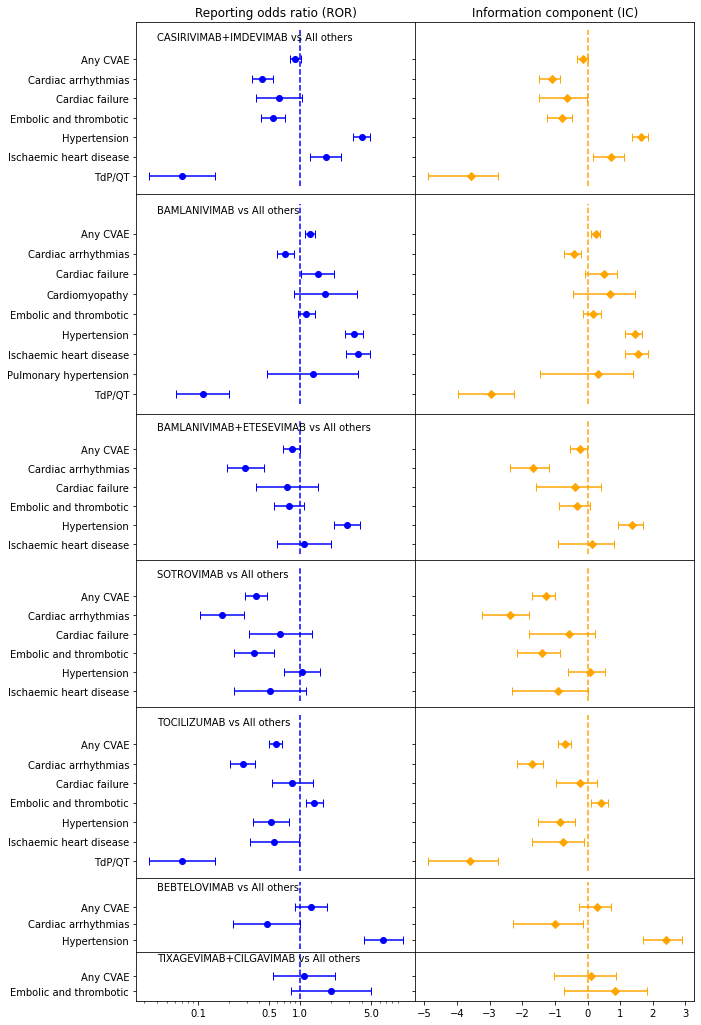

In [83]:
ylabels_CVAE = {"total CVAE": "Any CVAE", 
                        "Cardiac arrhythmias ": "Cardiac arrhythmias",
                        "Cardiac failure": "Cardiac failure",
                        "Cardiomyopathy ": "Cardiomyopathy",
                        "Hypertension": "Hypertension",
                        "Ischaemic heart disease ": "Ischaemic heart disease",
                        "Pulmonary hypertension": "Pulmonary hypertension",
                        "Embolic and thrombotic events ": "Embolic and thrombotic", 
                        "Torsade de pointes/QT prolongation": "TdP/QT"}
plot_ROR(disprop_df, ylabels_CVAE, "CVAE disproportionality.png")

### Outcome analysis  

The outcome of the event was reported with the following code:  

- DE        Death 
- LT        Life-Threatening 
- HO        Hospitalization - Initial or Prolonged  
- DS        Disability 
- CA        Congenital Anomaly 
- RI        Required Intervention to Prevent Permanent Impairment/Damage 
- OT        Other Serious (Important Medical Event)

We also compared the outcome of each monoclonal antibody treatment with all other treatment that does not contain the specific monoclonal antidoby.

In [84]:
outcome_list = ["CA", "DE", "DS", "HO", "LT", "OT", "RI"]
outcome_disprop = pd.DataFrame()
outcome_overview = pd.concat([cvae_overview.iloc[[0]], cvae_overview.iloc[-7:]], axis=0)
n_reports = outcome_overview.loc["Total reports", "All treatment"]
for d in ma_drug_case_selected.keys():
    drug_label = pd.Series(d + " vs All others", index=outcome_list)
    event_intervention = outcome_overview.loc[outcome_list, d]
    other_event_intervention = outcome_overview.loc["Total reports", d] - event_intervention
    event_comparator = outcome_overview.loc[outcome_list, "All treatment"] - event_intervention
    other_event_comparator = n_reports - outcome_overview.loc["Total reports", d] - event_comparator
    temp = {
        "drug label" : drug_label,
        "event intervention" : event_intervention,
        "other event intervention" : other_event_intervention,
        "event comparator" : event_comparator,
        "other event comparator": other_event_comparator
    }
    outcome_disprop = pd.concat([outcome_disprop, pd.DataFrame(temp).reset_index()], axis=0, ignore_index=True)

a, b, c, d = "event intervention", "other event intervention", "event comparator", "other event comparator"
outcome_disprop["ROR"] = (outcome_disprop[a] / outcome_disprop[b]) / (outcome_disprop[c] / outcome_disprop[d])
outcome_disprop["SE_logROR"] = np.sqrt(1/outcome_disprop[a] + 1/outcome_disprop[b] + 1/outcome_disprop[c] + 1/outcome_disprop[d])
outcome_disprop["CI95_low"] = outcome_disprop["ROR"] * np.exp(-1.96*outcome_disprop["SE_logROR"])
outcome_disprop["CI95_high"] = outcome_disprop["ROR"] * np.exp(1.96*outcome_disprop["SE_logROR"])
N_exp = ((outcome_disprop[a] + outcome_disprop[b]) * (outcome_disprop[a] + outcome_disprop[c])) / (outcome_disprop[a] + outcome_disprop[b] + outcome_disprop[c] + outcome_disprop[d])
outcome_disprop["IC"] = np.log2((outcome_disprop[a] + 0.5) / (N_exp + 0.5))
outcome_disprop["IC_025"] = outcome_disprop["IC"] - 3.3 * (outcome_disprop[a] + 0.5)**(-1/2) - 2 * (outcome_disprop[a] + 0.5)**(-3/2)
outcome_disprop["IC_975"] = outcome_disprop["IC"] + 2.4 * (outcome_disprop[a] + 0.5)**(-1/2) - 0.5 * (outcome_disprop[a] + 0.5)**(-3/2)


In [85]:
outcome_disprop.to_csv("outcome disproportionality.csv")

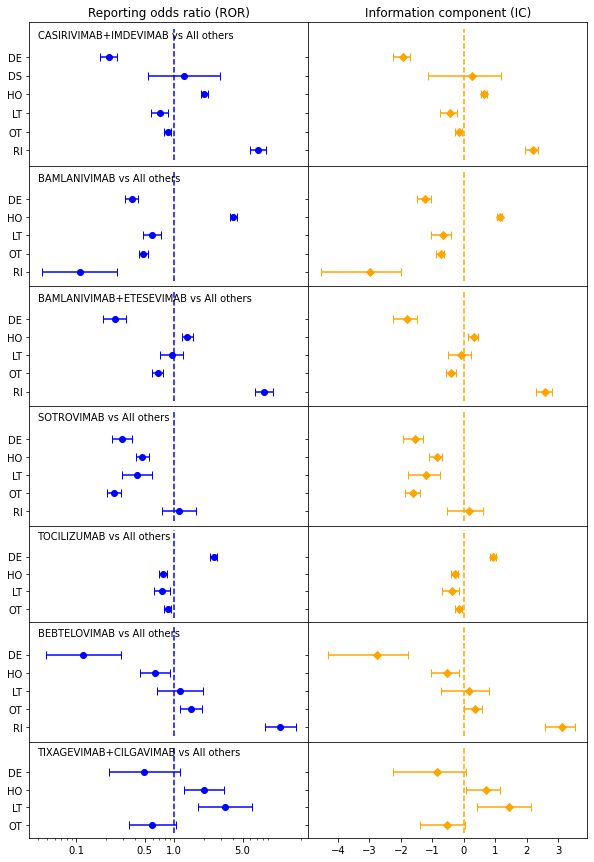

In [86]:
ylables_outcome = {i:i for i in outcome_cod}
plot_ROR(outcome_disprop, ylables_outcome)

The above figure shows the ROR of different outcomes for each manoclonal antibody treatment. Many of these monoclonal antibodies have decreased odds for severe outcomes (such as death and life-threatening). Only tocilizumab shows increased odds of death. However, this is not necessarily caused by the drug, but more likely related to the illness severity of the patient. Under the terms of EUA, tocilizumab is used by health care providers to treat hospitalized COVID-19 patients with severe illness.

In [87]:
def count_outc(caseids):
    return outc[outc["caseid"].isin(caseids)].groupby("outc_cod")["caseid"].nunique().sort_index()

outc_chi2 = pd.DataFrame()
for d in ma_drug_case_selected:
    cases_with_outc = set(outc.loc[outc["caseid"].isin(ma_drug_case_selected[d]), "caseid"])
    cvae_set = set(reac[reac["caseid"].isin(cases_with_outc)].merge(cvae_pt, on="pt")["caseid"])
    non_cvae_set = cases_with_outc - cvae_set
    temp_dict = {
        "outc_total": count_outc(cases_with_outc),
        "outc_CVAE": count_outc(cvae_set),
        "outc_non_CVAE": count_outc(non_cvae_set)
    }
    df = pd.DataFrame(temp_dict).fillna(0).astype(int).reset_index()
    df["drug_name"] = d
    df["all_cases_with_outc"] = len(cases_with_outc)
    df["all_CVAE_cases"] = len(cvae_set)
    df["all_non_CVAE_cases"] = len(non_cvae_set)
    df["other_outc_CVAE"] = df["all_CVAE_cases"] - df["outc_CVAE"]
    df["other_outc_non_CVAE"] = df["all_non_CVAE_cases"] - df["outc_non_CVAE"]
    outc_chi2 = pd.concat([outc_chi2, df], axis=0, ignore_index=True)

outc_chi2["outc_percent_CVAE"] = outc_chi2["outc_CVAE"] / outc_chi2["all_CVAE_cases"]
outc_chi2["outc_percent_non_CVAE"] = outc_chi2["outc_non_CVAE"] / outc_chi2["all_non_CVAE_cases"]

Below is the 2x2 contingency table to test whether the outcome is independent of CVAE

|  | CVAE | non-CVAE |
|-------|-------|-------|
| outcome | outc_CVAE | outc_non_CVAE |
| other come | other_outc_CVAE | other_outc_non_CVAE |
|  | all_CVAE_cases | all_non_CVAE_cases |

When any of the observed numbers is less than 10, Fisher's extract test was used. Others were tested using Pearson's chi-squared test

In [88]:
import scipy.stats as stats

In [89]:
def calculate_pvalue(a, b, c, d):
    table = np.array([[a, b], [c, d]])
    if np.any(table <= 10):
        _, p_value = stats.fisher_exact(table)
    else:
        chi1, p_value, dof, _ = stats.chi2_contingency(table, correction=False)
    return p_value

In [90]:
outc_chi2["p_value"] = outc_chi2.apply(lambda row: calculate_pvalue(row["outc_CVAE"], row["outc_non_CVAE"], 
                                                                    row["other_outc_CVAE"], row["other_outc_non_CVAE"]), axis=1)

reorder_columns = outc_chi2.columns[[4, 5, 6, 7, 0, 1, 2, 3, 8, 9, 10, 11, 12]]
outc_chi2 = outc_chi2[reorder_columns]

In [91]:
outc_chi2[["drug_name", "outc_cod", "outc_CVAE", "outc_percent_CVAE", "outc_non_CVAE", "outc_percent_non_CVAE", "p_value"]]

,drug_name,outc_cod,outc_CVAE,outc_percent_CVAE,outc_non_CVAE,outc_percent_non_CVAE,p_value
0,CASIRIVIMAB+IMDEVIMAB,CA,0,0.000000,1,0.000512,1.000000
1,CASIRIVIMAB+IMDEVIMAB,DE,22,0.085271,87,0.044501,0.004451
2,CASIRIVIMAB+IMDEVIMAB,DS,0,0.000000,6,0.003069,1.000000
3,CASIRIVIMAB+IMDEVIMAB,HO,138,0.534884,867,0.443478,0.005578
4,CASIRIVIMAB+IMDEVIMAB,LT,21,0.081395,82,0.041944,0.004694
5,CASIRIVIMAB+IMDEVIMAB,OT,62,0.240310,729,0.372890,0.000030
6,CASIRIVIMAB+IMDEVIMAB,RI,15,0.058140,183,0.093606,0.060661
7,BAMLANIVIMAB,DE,42,0.123167,135,0.072776,0.001680
8,BAMLANIVIMAB,DS,0,0.000000,1,0.000539,1.000000
9,BAMLANIVIMAB,HO,210,0.615836,1195,0.644205,0.315880


In [92]:
outc_chi2.to_csv("outcome CVAE chi2 test.csv")

### Sensitivity analysis  

To perform sensitivity analysis, we remove consumer and lawyer reported cases from the dataset, and only keep physician, pharmacist, and other health-professional reported cases. Then we re-run the code with filtered dataset and compare the results of the disproportionality analysis.